**To make sure that python is used from the newly created enviornment**


In [1]:
import sys
sys.executable

'C:\\Users\\hp India\\anaconda3\\envs\\mlops\\python.exe'

In [10]:
!python --version

Python 3.9.0


### Create functions for all the steps involved in complete model training lifecycle

In [3]:
import pandas as pd
import numpy as np

In [5]:
def load_data(path):
    data = pd.read_csv(path)
    return data

In [6]:
data = load_data("https://raw.githubusercontent.com/TripathiAshutosh/dataset/main/banking.csv")

In [11]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


### Data Pre-processing

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

As we can see, that for this particular dataset, we don't have missing values. But as a good practice, we will create a function to clean data

In [15]:
def data_cleaning(data):
    
    print("Null/missingalues available in the data: \n")
    print(data.isna().sum())
    data = data.dropna()
    print("The data after dropping the na values are: \n")
    print(data.isna().sum())
    
    return data


In [17]:
data['education'].value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

In [20]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
y                   int64
dtype: object

In [23]:
data.columns.values

array(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'], dtype=object)

In [25]:
def preprocessing(data):
    
    data['education'] = np.where(data['education'] == 'basic.9y', 'Basic', data['education'])
    data['education'] = np.where(data['education'] == 'basic.6y', 'Basic', data['education'])
    data['education'] = np.where(data['education'] == 'basic.4y', 'Basic', data['education'])
    
    categorical_vars = ['job','marital','education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
    for var in categorical_vars:
        cat_list = 'var' + '_' + var
        cat_list = pd.get_dummies(data[var], prefix = var)
        data_new = data.join(cat_list)
        data = data_new
    
    categorical_vars = ['job','marital','education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
    
    data_vars = data.columns.values.tolist()
    
    keeping = [i for i in data_vars if i not in categorical_vars]
    
    final_df = data[keeping]
    
    final_df.columns = final_df.columns.str.replace(".", "_")
    final_df.columns = final_df.columns.str.replace(" ", "_")
    
    return final_dataframe
    

### Train-Test Split

In [26]:
def train_test_split(final_df):
    from sklearn.model_selection import train_test_split
    X = final_df.loc[:, final_df.columns != 'y']
    y = final_df.loc[:, final_df.columns == 'y']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 47)
    
    return X_train, X_test, y_train, y_test

In [28]:
data['y'].value_counts()
# we can see that it is a highly imbalanced dataset

y
0    36548
1     4640
Name: count, dtype: int64

### Over_Sampling the dataset

In [51]:
def over_sampling_target_class(X_train, y_train):
    from imblearn.over_sampling import SMOTE
    
    os = SMOTE(random_state = 0)
    columns = X_train.columns
    
    os_data_X, os_data_y = os.fit_resample(X_train,y_train)
    
    os_data_X = pd.DataFrame(data = os_data_X, columns = columns)
    os_data_y = pd.DataFrame(data = os_data_y, columns = ['y'])
    
    # to check the numbers of the data
    print("The length of the oversampled data is : ", len(os_data_X))
    print("The number of positive class labels in the oversampled data are: ", len(os_data_y[os_data_y['y'] == 1]))
    print("The number of negative class labels in the oversampled data are: ", len(os_data_y[os_data_y['y'] == 0]))
    
    X_train = os_data_X
    y_train = os_data_y['y']
    
    return X_train, y_train


## Experiment-1 (Basic classifier) function 
##### (no hypyerparamater tuning)

In [30]:
def training_basic_classifier(X_train,y_train):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=101)
    model.fit(X_train, y_train)
    
    return model

In [31]:
def predict_on_test_data(model,X_test):
    y_pred = model.predict(X_test)
    return y_pred

In [32]:
def predict_prob_on_test_data(model,X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

## Evaluation Metrics

In [33]:
def get_metrics(y_true, y_pred, y_pred_prob):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,log_loss
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_prob)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}


## Visual Evaluation metrics

In [63]:
def create_roc_auc_plot(clf, X_data, y_data):
    import matplotlib.pyplot as plt
    from sklearn import metrics
    metrics.RocCurveDisplay.from_estimator(clf, X_data, y_data) 
    plt.savefig('roc_auc_curve.png')

"\ndef create_confusion_matrix_plot(clf, X_test, y_test):\n    import matplotlib.pyplot as plt\n    from sklearn.metrics import ConfusionMatrixDisplay.from_estimator\n    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)\n    plt.savefig('confusion_matrix.png')\n"

# Experiment 2 (Optimized classifer) 
 ##### (with hyperparameter tuning of Random Forest)

In [36]:
def hyper_parameter_tuning(X_train, y_train):
    # define random parameters grid
    n_estimators = [5,21,51,101] # number of trees in the random forest
    max_features = ['auto', 'sqrt'] # number of features in consideration at every split
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
    min_samples_split = [2, 6, 10] # minimum sample number to split a node
    min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
    bootstrap = [True, False] # method used to sample data points

    random_grid = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap
                  }
    
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier()
    model_tuning = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid,
                   n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
    model_tuning.fit(X_train, y_train)

    print ('Random grid: ', random_grid, '\n')
    # print the best parameters
    print ('Best Parameters: ', model_tuning.best_params_, ' \n')

    best_params = model_tuning.best_params_
    
    n_estimators = best_params['n_estimators']
    min_samples_split = best_params['min_samples_split']
    min_samples_leaf = best_params['min_samples_leaf']
    max_features = best_params['max_features']
    max_depth = best_params['max_depth']
    bootstrap = best_params['bootstrap']
    
    model_tuned = RandomForestClassifier(n_estimators = n_estimators, min_samples_split = min_samples_split,
                                         min_samples_leaf= min_samples_leaf, max_features = max_features,
                                         max_depth= max_depth, bootstrap=bootstrap) 
    model_tuned.fit( X_train, y_train)
    return model_tuned,best_params

## Executing the functions

In [38]:
data = load_data('https://raw.githubusercontent.com/TripathiAshutosh/dataset/main/banking.csv')

In [40]:
cleaned_data = data_cleaning(data)

Null/missingalues available in the data: 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
The data after dropping the na values are: 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64


In [41]:
final_data = preprocessing(cleaned_data)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(final_data)

In [52]:
X_train, y_train = over_sampling_target_class(X_train, y_train)

The length of the oversampled data is :  51166
The number of positive class labels in the oversampled data are:  25583
The number of negative class labels in the oversampled data are:  25583


In [53]:
model = training_basic_classifier(X_train,y_train)

In [54]:
y_pred = predict_on_test_data(model,X_test)

In [55]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [56]:
y_pred_prob = predict_prob_on_test_data(model,X_test)
y_pred_prob

array([[1.        , 0.        ],
       [0.97029703, 0.02970297],
       [0.93069307, 0.06930693],
       ...,
       [1.        , 0.        ],
       [0.74257426, 0.25742574],
       [1.        , 0.        ]])

In [81]:
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
run_metrics

{'accuracy': 0.91, 'precision': 0.62, 'recall': 0.53, 'entropy': 0.2}

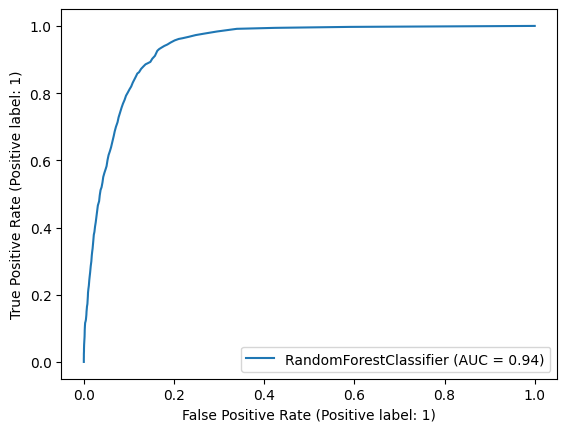

In [64]:
create_roc_auc_plot(model, X_test, y_test)

# MLFlow

In [78]:
experiment_name = "basic_classifier"  #Experiment 1
run_name="term_deposit"

run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
print(run_metrics)

{'accuracy': 0.91, 'precision': 0.62, 'recall': 0.53, 'entropy': 0.2}


In [86]:
create_experiment(experiment_name,run_name,run_metrics,model, 'roc_auc_curve.png')

Run - term_deposit is logged to Experiment - basic_classifier


## Function to create an experiment in MLFlow and log parameters, metrics and artifacts files like images etc.

In [85]:
def create_experiment(experiment_name,run_name, run_metrics,model, roc_auc_plot_path = None, run_params=None):
    import mlflow
    #mlflow.set_tracking_uri("http://localhost:5000") #uncomment this line if you want to use any database like sqlite as backend storage for model
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run():
        
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        mlflow.sklearn.log_model(model, "model")
            
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})
            
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))


## Create another experiment after tuning hyperparameters and log the best set of parameters for which model gives the optimal performance

In [72]:
import mlflow
experiment_name = "optimized model"
run_name="Random_Search_CV_Tuned_Model"
model_tuned,best_params = hyper_parameter_tuning(X_train, y_train)
run_params = best_params

y_pred = predict_on_test_data(model_tuned,X_test) #will return the predicted class
y_pred_prob = predict_prob_on_test_data(model_tuned,X_test) #model.predict_proba(X_test)
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 